In [12]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx

In [13]:
from featureExtraction import featureExtraction
# from bundle_adjustment import bundleAdjuster


In [14]:
def loadImages(img_dir):
    img_names = os.listdir(img_dir)
    img_list = []
    # Load images
    for img_name in img_names:
        img = cv.imread(img_dir + img_name)
        img_list.append(img)

    return img_list

    

In [15]:
img_dir = "./data/setSmall/"
img_list = loadImages(img_dir)


In [16]:
fe = featureExtraction(img_list,method="FLANN")

In [17]:
fe.run()

Extracting SIFT features...
Generating matches...
Processing matches...
Computing homographies...
Computing adjacency matrix...


#### Visualizing the network

In [18]:
def display_network(adjacency_matrix):
    G = nx.Graph(adjacency_matrix)
    nx.draw(G, with_labels=True, font_weight='bold')
    plt.show()

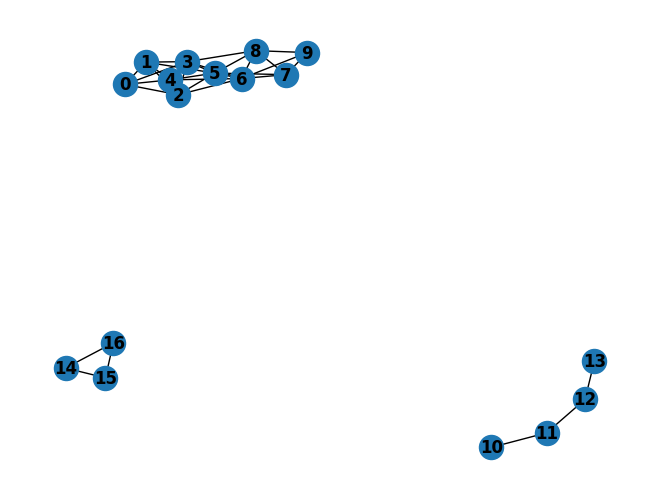

In [19]:
display_network(fe.adjacency_matrix)

In [27]:
import cv2 as cv
import numpy as np
import networkx as nx
import scipy.sparse.csgraph as csgraph
import scipy.optimize


class bundleAdjustment():

    def __init__(self,matches, numMatches, homographies, imgList,keypoints):
        self.matches = matches
        self.numMatches = numMatches
        self.homographies = homographies
        self.imgList = imgList
        self.kp = keypoints
        self.path = []
        self.paths = []

    def bfs(self, G, node):

        # create a queue for bfs
        queue = []
        # mark all the nodes as not visited
        visited = [False] * len(self.imgList)
        # mark the source node as visited and enqueue it
        visited[node] = True
        queue.append(node)
        while queue:
            # dequeue a vertex from queue and print it
            s = queue.pop(0)
            self.path.append(s)
            # get adjacent vertices of the dequeued vertex s
            # if a adjacent has not been visited, then mark it visited and enqueue it
            for i in G.neighbors(s):
                if visited[i] == False:
                    visited[i] = True
                    queue.append(i)

    def buildNetwork(self):
        G = nx.Graph(self.numMatches)
        # create connected components
        connected_components = list(nx.connected_components(G))
        # if a connected component has just 1 node, it is a single image, remove it
        connected_components = [x for x in connected_components if len(x) > 1]
        num_connected_components = len(connected_components)
        print("Number of panoramas detected: ", num_connected_components)
        # for each connected compnent apply mst algorithm
        for i in range(num_connected_components):
            # get the connected component
            connected_component = connected_components[i]
            # get the subgraph of the connected component
            subgraph = G.subgraph(connected_component)
            # get the minimum spanning tree of the subgraph
            # get weights of the edges from numMatches
            mst = nx.minimum_spanning_tree(subgraph)
            #  plot the mst
            nx.draw(mst, with_labels=True, font_weight='bold')
            plt.show()
            # find the node that has maximum number of matches with its neighbors
            # get the nodes of the mst
            nodes = list(mst.nodes())
            mode = "degree"
            max_matches = 0
            max_degree = 0
            index_node = 0
            if mode == "degree":
                for j in range(len(nodes)):
                    # get the degree of the node
                    degree = mst.degree(nodes[j])
                    if degree > max_degree:
                        max_degree = degree
                        index_node = j
            elif mode == "matches":
                for j in range(len(nodes)):
                    # check matches between with the neighboring nodes
                    # get neighbors of the node
                    neighbors = list(mst.neighbors(nodes[j]))
                    # get the number of matches between the node and its neighbors
                    num_matches = 0
                    for neighbor in neighbors:
                        num_matches += self.numMatches[nodes[j]][neighbor]
                    if num_matches > max_matches:
                        max_matches = num_matches
                        index_node = j

            # apply dfs from the node with maximum number of matches
            # print(index_node, nodes[index_node])
            self.bfs(mst, nodes[index_node])
            self.paths.append(self.path)
            self.path = []


    def bundleAdjuster(self, path):
        # start with the first image, its homography is identity
        H = np.eye(3)
        # for every match between img[path[i]] and img[path[i+1]], compute residual
        # and update homography
        ba=[path[0]]
        for i in range(1,len(path)):
            # get the matches between img[path[i]] and img[path[i+1]]
            for j in ba:
                matches = self.matches[j][path[i]]
                if matches is None:
                    print("No matches between ", j, " and ", path[i])
                    continue
                # get the homography between img[path[i]] and img[path[i+1]]
                H = np.dot(self.homographies[j][path[i]], H)
                # get the coordinates of the matched points
                # get the coordinates of the matched points in img[path[i]]
                src_pts = np.float32([self.kp[j][m.queryIdx].pt for m in matches]).reshape(-1,1,2)
                # get the coordinates of the matched points in img[path[i+1]]
                dst_pts = np.float32([self.kp[path[i]][m.trainIdx].pt for m in matches]).reshape(-1,1,2)
                # define the residual function
                def residual(H, src_pts, dst_pts):
                    dst_pts_ = cv.perspectiveTransform(dst_pts, H.reshape(3,3))
                    return (dst_pts_ - src_pts).reshape(-1)
                # optimize the residual function using the Levenberg-Marquardt algorithm
                # flatten H to one dimension
                H = H.reshape(-1)
                result = scipy.optimize.least_squares(residual, H, args=(src_pts, dst_pts))
                # update the homography
                H = result.x.reshape(3,3)
            
            ba.append(path[i])

    
    def run(self):
        print("Building network and ordering...")
        self.buildNetwork()
        # return
        print("Performing bundle adjustment for each panorama...")
        for i in range(len(self.paths)):
            print("Panorama ",i+1)
            self.bundleAdjuster(self.paths[i])
        print("Completed bundle adjustment for all panoramas")
    


Building network and ordering...
Number of panoramas detected:  3


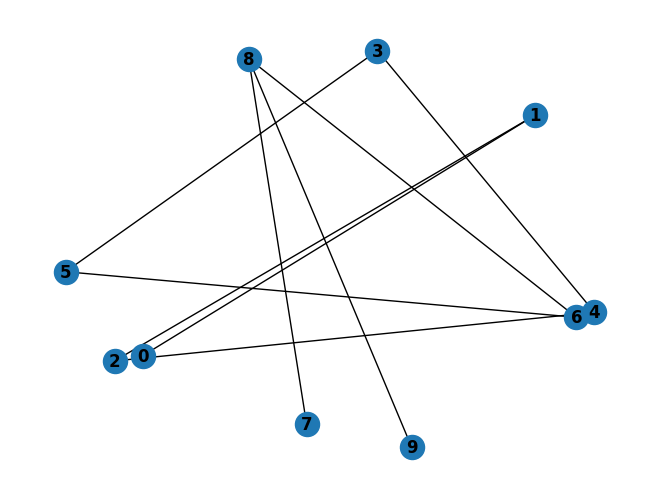

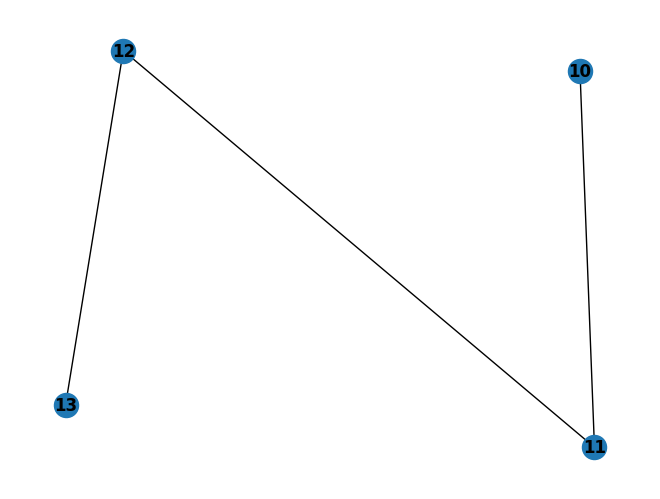

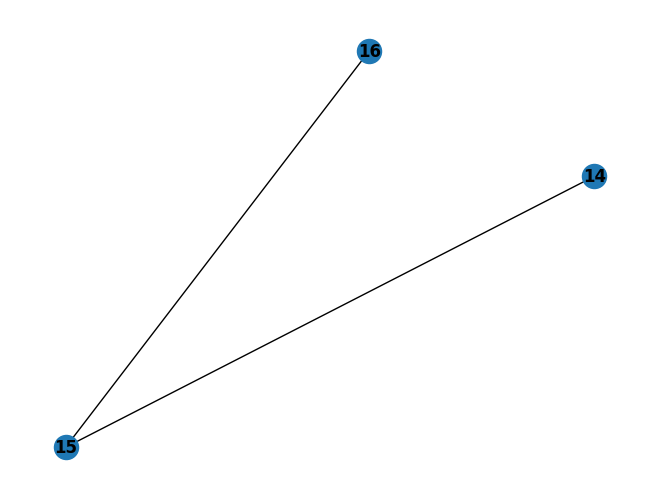

Performing bundle adjustment for each panorama...
Panorama  1
No matches between  6  and  9
No matches between  9  and  5
No matches between  7  and  3
No matches between  9  and  3
No matches between  8  and  4
No matches between  7  and  4
No matches between  9  and  4
No matches between  8  and  2
No matches between  7  and  2
No matches between  9  and  2
No matches between  8  and  1
No matches between  7  and  1
No matches between  6  and  1
No matches between  9  and  1
No matches between  5  and  1
No matches between  8  and  0
No matches between  7  and  0
No matches between  6  and  0
No matches between  9  and  0
No matches between  5  and  0
Panorama  2
No matches between  10  and  12
No matches between  11  and  13
No matches between  10  and  13
Panorama  3
Completed bundle adjustment for all panoramas


In [28]:
matches=fe.matches
homographies=fe.homographies
images=fe.image_list
adjacency_matrix=fe.adjacency_matrix
numMatches=np.zeros((len(img_list),len(img_list)))
for i in range(len(img_list)):
    for j in range(len(img_list)):
        if fe.matches[i][j]==None:
            numMatches[i,j]=0
            continue
        numMatches[i,j]=-len(fe.matches[i][j]) # we take -ve wts as we want to retain the edges with more matches while applying MST
BA=bundleAdjustment(matches,numMatches,homographies,images,fe.keypoints)
BA.run()

In [22]:
BA.paths

[[8, 7, 6, 9, 5, 3, 4, 2, 1, 0], [11, 10, 12, 13], [15, 16, 14]]